# 5. laboratorijska vježba
### Hodgkin-Huxley model neurona

Hodgkin-Huxley model neurona je dinamički vremenski kontinuirani sustav koji opisuje kako su **akcijski potencijali** pojedinog neurona inicijalizirani i propagirani. Akcijski potencijal je incijaliziran naglom promjenom membranskog potencijala na pojedinoj lokaciji stanice (u ovom slučaju neurona). Ova prvotna depolarizacija potom uzrokuje depolarizaciju susjednih lokacija i samim time lančanu pojavu promjene potencijala. U slučaju neurona, akcijski potencijal je informacija koja se prenosi od preko aksona jednog neurona do sinaptičkih veza i i potom do drugog neurona. Akcijski potencijali se često nazivaju i neuronski impulsi, a niz takvih impulsa u vremenu predstavlja neuronsku aktivnost. 
<center><img src="static/action-potential.gif" alt="action-potential-animation" width="400"/></center>
<center>~ Izvor <a href="https://en.wikipedia.org/wiki/Action_potential#/media/File:Action_Potential.gif">Wikipedia ~</a></center>


Incijalnu naglu promjenu membranskog potencijala uzrokuju specijalni tipovi naponski usmjerenih ionskih kanala ugrađenih u membranu stanicu. Ti su kanali zatvoreni kad je membranski potencijal blizu potencijala stanja mirovanja stanice, ali se brzo počinju otvarati ako se membranski potencijal poveća na definirani prag napona, depolarizirajući transmembranski potencijal. Kad se kanali otvore, unutarnji protok natrij (Na) iona je omogućen, ali se time mijenja elektrokemijski gradijent. Ova pojava uzrokuje daljnji porast membranskog potencijala prema nuli time uzrokujući otvaranje više kanala, proizvodeći veću električnu struju kroz staničnu membranu. Postupak se odvija eksplozivno sve dok se ne otvore svi dostupni ionski kanali, što rezultira velikim porastom membranskog potencijala. Brzi priljev Na iona uzrokuje da se polaritet plazmatske membrane preokrene, a ionski kanali se zatim brzo inaktiviraju. Kako se Na ionski kanali zatvaraju, Na ioni više ne mogu ući u neuron, a zatim se aktivno transportiraju natrag iz plazmatske membrane. Tada se aktiviraju kalij (K) ionski kanali i stvori se vanjska struja K iona, vraćajući elektrokemijski gradijent u stanje mirovanja. Nakon što je došlo do pojave akcijskog potencijala, dolazi do prolaznog negativnog pomaka, koji se naziva posthiperpolarizacija.
<center><img src="static/ion-channels.png" alt="ion-channels" width="400"/></center>
<center>~ Izvor <a href="https://en.wikipedia.org/wiki/Voltage-gated_ion_channel#/media/File:Open_and_closed_conformations_of_ion_channels.png">Wikipedia ~</a></center>


Temelji se na setu od 4 nelinearne diferencijalne jednadžbe koje aproksimiraju električne karakteristike neuronske aktivnosti koristeći distribuirane pasivne (električka svojstva nisu ovisna o vremenu) električne komponente. Slika ispod prikazuje osnovnu determinističku izvedbu Hodgkin-Huxley modela:
<center><img src="static/hodgkin-huxley-model.svg" alt="hodgkin-huxley-model" width="400"/></center>
<center>~ Izvor <a href="https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model#/media/File:Hodgkin-Huxley.svg">Wikipedia ~</a>
    
Lipidni dvosloj je predstavljen kao kondenzator uz pripadni kapacitet $C_m$. Naponsko-usmjereni i propuštajući ionski kanali su redom predstavljeni kroz vodljivosti $g_n$ i $g_L$. Elektrokemijski gradijenti koji definiraju protok iona kroz neuron su predstavljeni kao naponski izvori strujnog kruga, $E_n$ i $E_L$. Ionske pumpe su predstavljene kao strujni izvor, $I_p$.</center>

Ukoliko je membranski potencijal definiran kroz iznos $V_m$, za struju koja prolazi kroz lipidni dvosloj vrijedi:

$$
I_c = C_m \frac{d V_m}{dt}
$$

a za struju koja prolazi kroz $i$-ti ionski kanal vrijedi:

$$
I_i = g_i (V_m - V_i)
$$

pri čemu je $V_i$ reverzni potencijal $i$-tog ionskog kanala.

Kako ćemo kroz ove laboratorijske vježe razmatrati neuron sa Na i K ionskim kanalima, ukupna struja kroz membranu se može zapisati, koristeći Kirchoffov zakon, kao:

$$
I = C_m \frac{d V_m}{dt} + g_K (V_m - V_K) + g_{Na} (V_m - V_{Na}) + g_L (V_m - V_L)
$$

Elementi $V_m$, $g_{Na}$ i $g_{K}$ su vremenski ovisni, pri čemu vodljivosti $g_{Na}$ i $g_{K}$ osim o vremenu, ovise i o membranskom naponu.

Kako se ionski kanali mogu razmatrati u različitim stanjima, potrebno je dodati aktivacijske parametre za svaki kanal:

$$
I = C_m \frac{d V_m}{dt} + \hat g_K \cdot n^4 \cdot (V_m - V_K) + \hat g_{Na} \cdot m^4 \cdot h \cdot (V_m - V_{Na}) + g_L (V_m - V_L)
$$

pri čemu kvačica iznad svake vodljivosti označava maksimalnu vodljivost za promatrani tip ionskog kanala. Dinamika aktivacijskih parametara, $n$, $m$ i $h$, je opisana kroz jednadžbe:

$$
\begin{align}
\frac{dn}{dt} &= \alpha_n(V_m)(1 - n) - \beta_n(V_m) n \\
\frac{dm}{dt} &= \alpha_m(V_m)(1 - m)  - \beta_m(V_m) m \\
\frac{dh}{dt} &= \alpha_h(V_m)(1 - h) - \beta_h(V_m) h
\end{align}
$$

Parametri $\alpha_n$, $\alpha_m$, $\alpha_h$ te $\beta_n$, $\beta_m$ i $\beta_h$ predstavljaju dinamiku otvaranja/zatvaranja ionskih kanala i ovise o naponu na membrani. Predstavljeni su koristeći Boltzmannove jednadžbe kao funkcija od $V_m$ a njihova vrijednost može biti u rasponu [0, 1]:

$$
\begin{align}
\alpha_n(V_m) = \frac{0.01(10-V_m )}{\exp\big(\frac{10-V_m}{10}\big)-1} &\quad \alpha_m(V_m) = \frac{0.1(25-V_m)}{\exp\big(\frac{25-V_m}{10}\big)-1} &\quad \alpha_h(V_m) = 0.07\exp\bigg(\frac{-V_m}{20}\bigg)\\
\beta_n(V_m) = 0.125\exp\bigg(\frac{-V_m}{80}\bigg) &\quad  \beta_m(V_m) = 4\exp\bigg(\frac{-V_m}{18}\bigg) &\quad \beta_h(V_m) = \frac{1}{\exp\big(\frac{30-V_m}{10}\big) + 1}
\end{align}
$$


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [54]:
class HodgkinHuxley(object):
    """Full Hodgkin-Huxley Model implementation.
    Original implementation: 
    https://hodgkin-huxley-tutorial.readthedocs.io/en/latest/_static/Hodgkin%20Huxley.html
    """
    def __init__(self, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L):
        """Constructor.
        
        Parameters
        ----------
        C_m : float
            Membrane capacitance [F/cm^2]
        g_Na : float
            Sodium (Na) maximum conductances [mS/cm^2]
        g_K : float
            Postassium (K) maximum conductances [mS/cm^2]
        g_L : float
            Leak maximum conductances [mS/cm^2]
        E_Na : float
            Sodium (Na) reversal potentials [mV]
        E_K : float
            Postassium (K) reversal potentials [mV]
        E_L : float
            Leak reversal potentials [mV]
        
        Returns
        -------
        None
        """
        self.C_m = C_m 
        self.g_Na = g_Na
        self.g_K  = g_K 
        self.g_L  = g_L 
        self.E_Na = E_Na
        self.E_K = E_K 
        self.E_L = E_L 

    def alpha_m(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 0.125*np.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """Return the value of Na membrane current.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Na membrane current density [uA/cm^2]
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """Return the value of K membrane current.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            K membrane current density [uA/cm^2]
        """
        return self.g_K * n**4 * (V - self.E_K)
    
    def I_L(self, V):
        """Return the value of leak current.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Leak current density [uA/cm^2]
        """
        return self.g_L * (V - self.E_L)

    def I_inj(self, t):
        """Return the external current values over simulation time, `t`.
        
        Parameters
        ----------
        t : float
            Simulation time point
            
        Returns
        -------
        numpy.ndarray
            External current density [uA/cm^2]:
            step up to 10 uA/cm^2 at t>100
            step down to 0 uA/cm^2 at t>200
            step up to 35 uA/cm^2 at t>300
            step down to 0 uA/cm^2 at t>400
        """
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)

    def ode_system(self, initial_conds, t):
        """Hodgkin Huxley model based on a set of four coupled ODEs.
        For details, go here: https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model#Voltage-gated_ion_channels

        Parameters
        ----------
        initial_conds : list
            Initial conditions for membrane potential and m, h and n activation variables
        t : numpy.ndarray
            A sequence of time points for which to solve for y
            
        Returns
        -------
        tuple
            Membrane potential and m, h adn n activation variables
        """
        V, m, h, n = initial_conds

        dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return (dVdt, dmdt, dhdt, dndt)
    
    def simulate(self, initial_conds, t, ret=False, viz=False):
        """Hodgkin Huxley model based on a set of four coupled ODEs.
        For details, go here: https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model#Voltage-gated_ion_channels

        Parameters
        ----------
        initial_conds : list
            Initial conditions for membrane potential and m, h and n activation variables
        t : numpy.ndarray
            A sequence of time points for which to solve for y
        ret : bool, optional
            If True, calculated electrical parameters will be returned
        viz : bool, optional
            If True, simulation will be visualized
            
        Returns
        -------
        tuple or None
            if `ret` is set to True, tuple containg membrane potential, activation functions and currents will be returned
        """
        self.t = t
        sol = odeint(self.ode_system, initial_conds, self.t)
        V = sol[:, 0]
        m = sol[:, 1]
        h = sol[:, 2]
        n = sol[:, 3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)
        iinj = [self.I_inj(t) for t in self.t]
        
        if viz:
            fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8, 10))
            ax[0].plot(self.t, V)
            ax[0].set_ylabel('$V$ [mV]')
            ax[0].grid()

            ax[1].plot(self.t, ina, label='$I_{Na}$')
            ax[1].plot(self.t, ik, label='$I_{K}$')
            ax[1].plot(self.t, il, label='$I_{L}$')
            ax[1].set_ylabel('$I$ [$\\mu$A]')
            ax[1].legend()
            ax[1].grid()

            ax[2].plot(self.t, m, label='$m$')
            ax[2].plot(self.t, h, label='$h$')
            ax[2].plot(self.t, n, label='$n$')
            ax[2].set_ylabel('Gating activation')
            ax[2].legend()
            ax[2].grid()

            ax[3].plot(self.t, iinj)
            ax[3].set_xlabel('$t$ [ms]')
            ax[3].set_ylabel('$I_{inj}$ [$\\mu$A $\cdot$ $cm^{-2}$]')
            ax[3].grid()

            plt.tight_layout()
            plt.show()
        
        if ret:
            return (V, m, h, n, ina, ik, il, iinj)

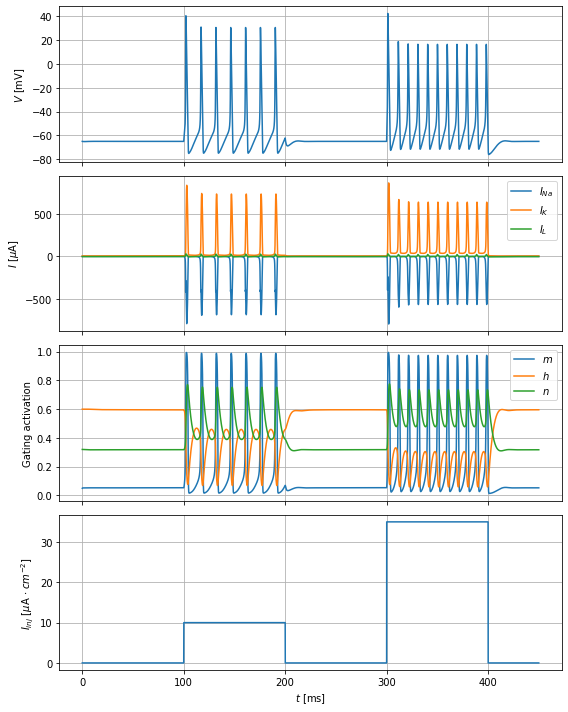

In [55]:
C_m = 1.0  # membrane capacitance [F/cm^2]
g_Na = 120.0  # Sodium (Na) maximum conductances [mS/cm^2]
g_K  = 36.0  # Postassium (K) maximum conductances [mS/cm^2]
g_L  = 0.3  # Leak maximum conductances [mS/cm^2]
E_Na = 50.0  # Sodium (Na) reversal potentials [mV]
E_K  = -77.0  # Postassium (K) reversal potentials [mV]
E_L  = -54.387  # Leak reversal potentials [mV]

initial_conds = [-65, 0.05, 0.6, 0.32]
t = np.arange(0.0, 450.0, 0.01)  # simulation time [ms]

model = HodgkinHuxley(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L)
V, m, h, n, ina, ik, il, iinj = model.simulate(initial_conds, t, ret=True, viz=True)

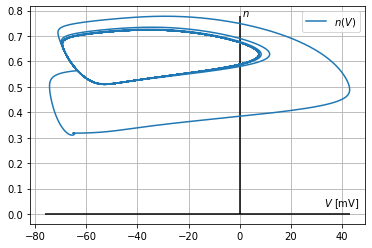

In [51]:
fig, ax = plt.subplots()
ax.plot(V[10000:30000], n[10000:30000], label='$n(V)$')
ax.hlines(0, V.min(), V.max())
ax.annotate('$n$', (1, n.max()))
ax.vlines(0, 0, n.max())
ax.annotate('$V$ [mV]', (V.max()-10, 0.03))
ax.legend()
ax.grid()
plt.show()